In [ ]:
import numpy as np
from scipy.optimize import fsolve
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import ElementwiseProblem
import matplotlib.pyplot as plt

# ODEs
def Equ1(x, y, beta_x, n):
    return beta_x / (1 + y**n) - x

def Equ2(x, y, beta_y, n):
    return beta_y * x**n / (1 + x**n) - y

# Define function to evaluate vector field
def Equs(P, t, params):
    x = P[0]
    y = P[1]
    beta_x = params[0]
    beta_y = params[1]
    n = params[2]
    val0 = Equ1(x, y, beta_x, n)
    val1 = Equ2(x, y, beta_y, n)
    return np.array([val0, val1])

# Sensitivity functions
def S_betay_yss_analytic(xss, yss, beta_x, beta_y, n):
    numer = beta_x * beta_y * xss**(n-1) * (1 + xss**n)
    denom = (1 + xss**n)**2 * yss + n**2 * beta_y * xss**n * yss**n + (1 + xss**n)**2 * yss**(1+n)
    sensitivity = numer / denom 
    return abs(sensitivity)

def S_n_yss_analytic(xss, yss, beta_x, beta_y, n):
    numer = n * beta_y * xss**n * (np.log(xss) + (np.log(xss) - n * np.log(yss)) * yss**n)
    denom = (1 + xss**n)**2 * yss + n**2 * beta_y * xss**n * yss**n + (1 + xss**n)**2 * yss**(1+n)
    sensitivity = numer / denom  
    return abs(sensitivity)

# Initial guesses
def generate_initial_guesses(beta_x_val, beta_y_val):
    return [
        np.array([1, 1]),
        np.array([0, 0]),
        np.array([0.3, 12.5]),
        np.array([50.5, 0.9]),
        np.array([67.6, 0.9]),
        np.array([21, 0.9])
    ]

def ssfinder(beta_x_val, beta_y_val, n_val):
    """
    Find the steady state (xss, yss) for given beta_x, beta_y, and n.
    """
    params = np.array([beta_x_val, beta_y_val, n_val])
    for init_guess in generate_initial_guesses(beta_x_val, beta_y_val):
        # Solve ODE system using fsolve
        output, infodict, intflag, _ = fsolve(
            Equs, init_guess, args=(0, params), xtol=1e-12, full_output=True
        )
        xss, yss = output
        fvec = infodict['fvec']
        # Check stability via Jacobian eigenvalues
        delta = 1e-8
        # Jacobian: df1/dx, df1/dy; df2/dx, df2/dy
        df1_dx = (Equ1(xss + delta, yss, params[0], params[2]) - Equ1(xss, yss, params[0], params[2])) / delta
        df1_dy = (Equ1(xss, yss + delta, params[0], params[2]) - Equ1(xss, yss, params[0], params[2])) / delta
        df2_dx = (Equ2(xss + delta, yss, params[1], params[2]) - Equ2(xss, yss, params[1], params[2])) / delta
        df2_dy = (Equ2(xss, yss + delta, params[1], params[2]) - Equ2(xss, yss, params[1], params[2])) / delta
        jac = np.array([[df1_dx, df1_dy], [df2_dx, df2_dy]])
        eig = np.linalg.eig(jac)[0]
        instability = np.any(np.real(eig) >= 0)
        # Validate solution: positive, small residual, stable, and converged
        if (xss > 0.04 and yss > 0.04 and np.linalg.norm(fvec) < 1e-10 and
                intflag == 1 and not instability):
            return xss, yss
    return np.nan, np.nan

class Sensitivity(ElementwiseProblem):
    """
    Define the multi-objective optimization problem to minimize sensitivities.
    Optimizes beta_x, beta_y, and n to minimize S_betay_yss and S_n_yss.
    """
    def __init__(self):
        super().__init__(
            n_var=3,  # Variables: beta_x, beta_y, n
            n_obj=2,  # Objectives: S_betay_yss, S_n_yss
            n_constr=0,
            xl=np.array([0.001, 0.001, 0.001]),  # Lower bounds
            xu=np.array([50.0, 50.0, 10.0])      # Upper bounds
        )

    def _evaluate(self, x, out, *args, **kwargs):
        """
        Evaluate the objectives for a given (beta_x, beta_y, n) set.
        """
        beta_x, beta_y, n = x
        xss, yss = ssfinder(beta_x, beta_y, n)
        if np.isnan(xss) or np.isnan(yss):
            out["F"] = [1e5, 1e5]  # Penalize invalid solutions
        else:
            out["F"] = [
                S_betay_yss_analytic(xss, yss, beta_x, beta_y, n),
                S_n_yss_analytic(xss, yss, beta_x, beta_y, n)
            ]

# Run the optimization
algorithm = NSGA2(pop_size=500)  # Population size
res = minimize(
    Sensitivity(),
    algorithm,
    ('n_gen', 200),  # Number of generations
    seed=1,
    verbose=True
)


/tmp/ipykernel_173306/2622604140.py:13: RuntimeWarning: invalid value encountered in scalar power
  return beta_y * x**n / (1 + x**n) - y
/tmp/ipykernel_173306/2622604140.py:10: RuntimeWarning: invalid value encountered in scalar power
  return beta_x / (1 + y**n) - x


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      500 |     19 |             - |             -
     2 |     1000 |     23 |  0.0147121413 |             f
     3 |     1500 |     37 |  0.0144052587 |             f
     4 |     2000 |     44 |  0.0109753028 |             f
     5 |     2500 |     61 |  0.0059085575 |             f
     6 |     3000 |     71 |  0.0027927530 |             f
     7 |     3500 |     95 |  0.0190852296 |         nadir
     8 |     4000 |    109 |  0.0018648821 |             f
     9 |     4500 |    135 |  0.0331117627 |         nadir
    10 |     5000 |    168 |  0.0018793818 |             f
    11 |     5500 |    211 |  0.0056222346 |         nadir
    12 |     6000 |    263 |  0.0007770482 |             f
    13 |     6500 |    321 |  0.0012808843 |             f
    14 |     7000 |    406 |  0.0017373808 |             f
    15 |     7500 |    475 |  0.0018965038 |             f
    16 |     8000 |    500 |  0.0021896182 |            

Found 500 non-dominated points in 23.692s


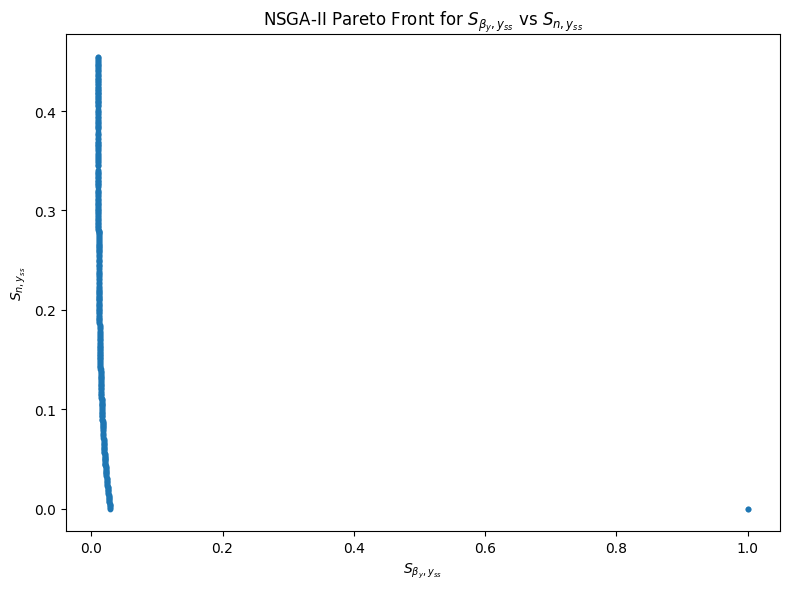

In [2]:

F = res.F  # Objective values (sensitivities)
X = res.X  # Parameter values (beta_x, beta_y, n)
print(f"Found {F.shape[0]} non-dominated points in {res.exec_time:.3f}s")

# Plot the Pareto front
plt.figure(figsize=(8, 6))
plt.scatter(F[:, 0], F[:, 1], s=10)
plt.xlabel(r'$S_{\beta_y,y_{ss}}$')  # Sensitivity of yss to beta_y
plt.ylabel(r'$S_{n,y_{ss}}$')  # Sensitivity of yss to n
plt.title(r'NSGA-II Pareto Front for $S_{\beta_y,y_{ss}}$ vs $S_{n,y_{ss}}$')
plt.tight_layout()
plt.show()